In [10]:
import numpy as np
from numpy import cos,sin
import scipy.integrate as integrate
from matplotlib import pyplot as plt
from matplotlib import animation,rc
from IPython.display import HTML
rc('animation',html='jshtml')

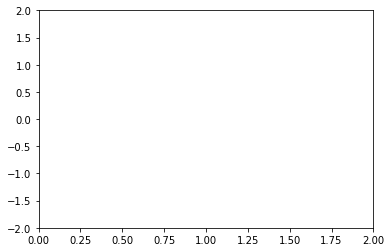

In [2]:
fig = plt.figure()
ax = plt.axes(xlim=(0,2),ylim=(-2,2))
line, = ax.plot([],[],lw=2)
def init():
    line.set_data([],[])
    return line,
def animate(i):
    x = np.linspace(0,2,1000)
    y = np.sin(2*np.pi*(x-0.01*i))
    line.set_data(x,y)
    return line,
anim = animation.FuncAnimation(fig,animate,init_func=init,frames=200,interval=20,blit=True)

In [3]:
anim

In [18]:
class DoublePendulum(object):
    """Double Pendulum Class

    init_state is [theta1, omega1, theta2, omega2] in degrees,
    where theta1, omega1 is the angular position and velocity of the first
    pendulum arm, and theta2, omega2 is that of the second pendulum arm
    """
    def __init__(self,init_state = [120,0,-20,0],
                L1=1.0,
                L2=1.0,
                M1=1.0,
                M2=1.0,
                g=9.8,
                origin=(0,0)):
        self.init_state = np.asarray(init_state,dtype='float')
        self.params = (L1,L2,M1,M2,g)
        self.origin = origin
        self.time_elapsed = 0
        self.state = self.init_state * np.pi/180
        
    def position(self):
        """compute the current x,y positions of the pendulum arms"""
        (L1,L2,M1,M2,g) = self.params
        x = np.cumsum([self.origin[0],L1*np.sin(self.state[0]),
                      L2*np.sin(self.state[2])])
        y = np.cumsum([self.origin[1],
                      -L1*np.cos(self.state[0]),
                      -L2*np.cos(self.state[2])])
        return (x,y)
    def energy(self):
        """compute the energy of the current state"""
        (L1,L2,M1,M2,g) = self.params
        x = np.cumsum([L1 * sin(self.state[0]),
                       L2 * sin(self.state[2])])
        y = np.cumsum([-L1 * cos(self.state[0]),
                       -L2 * cos(self.state[2])])
        vx = np.cumsum([L1 * self.state[1] * cos(self.state[0]),
                        L2 * self.state[3] * cos(self.state[2])])
        vy = np.cumsum([L1 * self.state[1] * sin(self.state[0]),
                        L2 * self.state[3] * sin(self.state[2])])
        U = g*(M1*y[0]+M2*y[1])
        K = 0.5*(M1*np.dot(vx,vx) + M2*np.dot(vy,vy) )
        return U,K,U+K
    
    def dstate_dt(self, state, t):
        """compute the derivative of the given state"""
        (M1, M2, L1, L2, G) = self.params

        dydx = np.zeros_like(state)
        dydx[0] = state[1]
        dydx[2] = state[3]

        cos_delta = cos(state[2] - state[0])
        sin_delta = sin(state[2] - state[0])

        den1 = (M1 + M2) * L1 - M2 * L1 * cos_delta * cos_delta
        dydx[1] = (M2 * L1 * state[1] * state[1] * sin_delta * cos_delta
                   + M2 * G * sin(state[2]) * cos_delta
                   + M2 * L2 * state[3] * state[3] * sin_delta
                   - (M1 + M2) * G * sin(state[0])) / den1

        den2 = (L2 / L1) * den1
        dydx[3] = (-M2 * L2 * state[3] * state[3] * sin_delta * cos_delta
                   + (M1 + M2) * G * sin(state[0]) * cos_delta
                   - (M1 + M2) * L1 * state[1] * state[1] * sin_delta
                   - (M1 + M2) * G * sin(state[2])) / den2
        
        return dydx
    
    def step(self,dt):
        """execute one time step of length dt and update state"""
        self.state = integrate.odeint(self.dstate_dt, self.state, [0, dt])[1]
        self.time_elapsed += dt

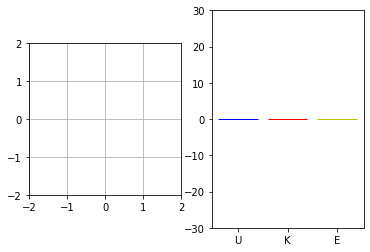

In [107]:
pendulum = DoublePendulum([180.,0.,20.,0.])
dt = 1./30
fig = plt.figure()
ax1 = fig.add_subplot(121, aspect='equal', autoscale_on=False,
                     xlim=(-2, 2), ylim=(-2, 2))
ax2 = fig.add_subplot(122)

ax1.grid()

line,=ax1.plot([],[],'o-',lw=2)
barcont=ax2.bar(['U','K','E'],[0,0,0])
ax2.set_ylim([-30,30])
barcont[0].set_color('b')
barcont[1].set_color('r')
barcont[2].set_color('y')
time_text = ax1.text(0.02,0.95,'',transform=ax1.transAxes)
energy_text = ax1.text(0.02, 0.90, '', transform=ax1.transAxes)
potential_text = ax1.text(0.02,0.85,'',transform=ax1.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    time_text.set_text('')
    potential_text.set_text('')
    energy_text.set_text('')
    return line, time_text, energy_text,potential_text
def animate(i):
    """perform animation step"""
    global pendulum, dt,barcont
    pendulum.step(dt)
    line.set_data(*pendulum.position())
    time_text.set_text('time = %.1f' % pendulum.time_elapsed)
    energies = pendulum.energy()
    energy_text.set_text('energy = %.3f J' % energies[2])
    potential_text.set_text('potential = %.3f J' % energies[0])
    for rect, y in zip(barcont, energies):
        rect.set_height(y)
#     ax2.bar(['U','K','E'],energies)  
    return line, time_text, energy_text, potential_text

In [108]:
from time import time
t0 = time()
animate(0)
t1=time()
interval = 1000*dt-(t1-t0)
ani = animation.FuncAnimation(fig,animate,frames=300,interval=interval,blit=True,
                             init_func=init)

In [109]:
ani